In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold


In [ ]:
GITHUB_CDN = "https://raw.githubusercontent.com/realamirhe/github-stargazer"

tens = range(1, 10)

js_repo_urls = map(lambda idx: f"{GITHUB_CDN}/master/data/js-{idx}.csv", tens)
py_repo_urls = map(lambda idx: f"{GITHUB_CDN}/master/data/py-{idx}.csv", tens)
first_chunk_url =  f"{GITHUB_CDN}/master/data/datas.csv"
second_chunk_url =  f"{GITHUB_CDN}/master/data/datas-2.csv"

data_urls = [*js_repo_urls, *py_repo_urls, first_chunk_url, second_chunk_url]

In [ ]:
datas = pd.concat(list(map(pd.read_csv, data_urls)))
datas = datas.select_dtypes(exclude=['object'])
datas = datas.reset_index()
datas = datas.drop_duplicates()
datas = datas.drop(columns=['index', 'Unnamed: 0', 'score'], axis=1)
datas = datas.replace({ False: 0, True: 1 })
datas.head()

,private,owner.public_repos,owner.public_gists,owner.followers,owner.following,fork,forks,size,stargazers_count,watchers_count,...,has_pages,has_discussions,forks_count,archived,disabled,open_issues_count,allow_forking,is_template,web_commit_signoff_required,watchers
0,0,64,62,23302,11,0,540,7954,1962,1962,...,0,0,540,0,0,30,1,0,0,1962
1,0,274,758,10063,11,0,61,3462,435,435,...,0,0,61,0,0,13,1,0,0,435
2,0,50,0,11,0,0,605,168196,3031,3031,...,0,0,605,0,0,15,1,0,0,3031
3,0,64,62,23302,11,0,516,2639,2200,2200,...,1,0,516,0,0,247,1,0,0,2200
4,0,58,50,195,16,0,7,192,68,68,...,0,0,7,0,0,1,1,0,0,68


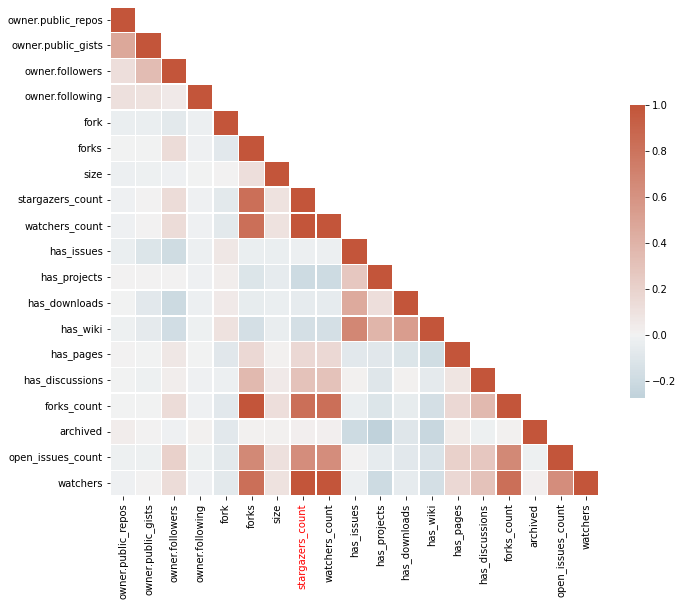

In [ ]:
keep = [c for c in list(datas) if len(datas[c].unique()) > 1]
corr = datas[keep].corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax1 = sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .6})

for tick_label in ax1.xaxis.get_ticklabels():
  tick_label.set_color('red' if tick_label.get_text() == 'stargazers_count' else 'black')

In [ ]:
def cut_binary(y):
  startruck_ranges = (-np.inf,2.5,np.inf)
  startruck_labels = [0, 1]

  y = np.log(y + 0.001)
  y = pd.cut(y, [i-1 for i in startruck_ranges], labels=startruck_labels)
  y = y.astype(np.float64)
  return y

# remove high correlated datas
y = datas['stargazers_count']
X = datas.drop(columns=['stargazers_count', 'watchers', 'watchers_count'])

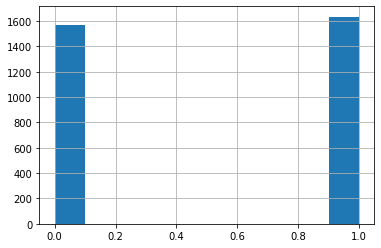

In [ ]:
y_catted_bin=cut_binary(y)
y_catted_bin.hist()

## PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
n_components = 5
pca = PCA(n_components)
pca.fit(X)

print(f"Only {n_components} component can cover {np.sum(pca.explained_variance_ratio_)*100:.3f}% of data")

Only 5 component can cover 99.999% of data


## Test Split

In [ ]:
from sklearn.model_selection import train_test_split

y_binary = cut_binary(y)
x_train, x_test, y_train, y_test = train_test_split(
    pca.transform(X), 
    y_binary, 
    test_size=0.2, 
    random_state=42,
    stratify=y_binary
)

## TSNE

In [ ]:
from time import time
from sklearn import manifold
from matplotlib.ticker import NullFormatter

In [ ]:
# https://github.com/community/community/discussions/20560
y = datas['stargazers_count']
def cut_startruck(y):
  startruck_ranges = (0, 1, 16, 128, 512, 4096, 16384, 65536, 262144)
  startruck_labels = [0, 1, 2, 3, 4, 5, 6, 7]

  y_cutted = pd.cut(y, [i-1 for i in startruck_ranges], labels=startruck_labels)
  startruck_missing_value = len(startruck_labels) + 1
  y_cutted = y_cutted.cat.add_categories(startruck_missing_value).fillna(startruck_missing_value)
  return y_cutted

y_cutted = cut_startruck(y)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE: 46 sec


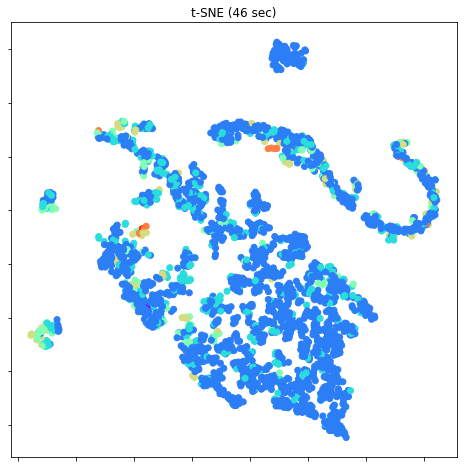

In [ ]:
t0 = time()
tsne = manifold.TSNE(n_components=2, random_state=0)
trans_data = tsne.fit_transform(X).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 1, 1)
jitter = np.random.random(trans_data.shape) * 2
plt.scatter(
    trans_data[0] + jitter[0, :], 
    trans_data[1] + jitter[1, :], 
    c=y_cutted,
    cmap=plt.cm.rainbow
)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
plt.axis("tight")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.show()

In [ ]:
def cut_y(y):
  # https://github.com/community/community/discussions/20560
  startruck_ranges = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,32,64,128,512,1024,2048,4096)
  startruck_labels = list(range(len(startruck_ranges) -1))
  y_cutted = pd.cut(y, [i-1 for i in startruck_ranges], labels=startruck_labels)
  startruck_missing_value = len(startruck_labels) + 1
  y_cutted = y_cutted.astype(np.float64)
  y_cutted[np.isnan(y_cutted)] = startruck_missing_value
  return y_cutted.astype(np.int8)
  

y = datas['stargazers_count']
y_cutted = cut_y(y)

In [ ]:
y_cutted

0       21
1       19
2       22
3       22
4       18
        ..
4827    17
4828     3
4829    19
4830     1
4831     2
Name: stargazers_count, Length: 3203, dtype: int8

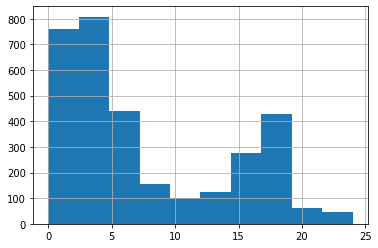

In [ ]:
y_cutted.hist()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE: 22 sec


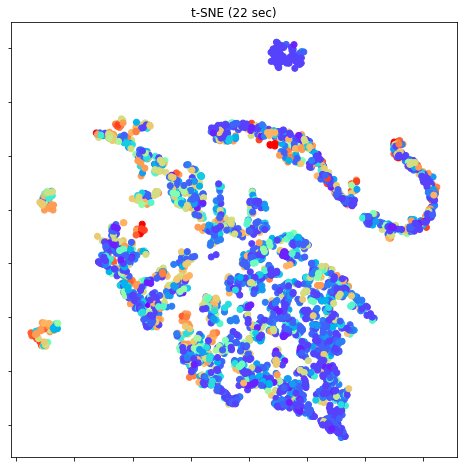

In [ ]:
t0 = time()
tsne = manifold.TSNE(n_components=2, random_state=0)
trans_data = tsne.fit_transform(X).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 1, 1)
jitter = np.random.random(trans_data.shape) * 2
plt.scatter(
    trans_data[0] + jitter[0, :], 
    trans_data[1] + jitter[1, :], 
    c=y_cutted,
    cmap=plt.cm.rainbow
)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
plt.axis("tight")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.show()

## KNN

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

Text(0.5, 1.0, '5-fold cross validation for KNN')

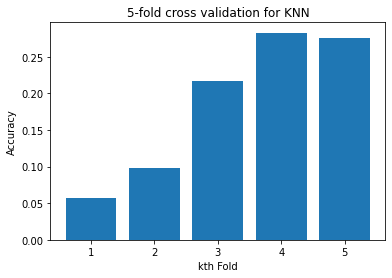

In [ ]:
# k-fold
from sklearn.neighbors import KNeighborsClassifier

kf = KFold(n_splits=5)
# model
knn = KNeighborsClassifier(n_neighbors=4)
# bechmark
acc = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    clf = knn.fit(X.iloc[train_index], y.iloc[train_index])
    y_pred = clf.predict(X.iloc[test_index])
    y_pred = cut_y(y_pred)
    y_true = y.iloc[test_index]
    acc.append(accuracy_score(y_true, y_pred))

plt.bar(np.arange(5)+1,acc)
plt.xlabel('kth Fold')
plt.ylabel('Accuracy')
plt.title('5-fold cross validation for KNN')

### Normalizing datas

In [ ]:
X_norm = X.copy()

for column in X_norm.columns:
    X_norm[column] = (X_norm[column] - X_norm[column].min()) / (X_norm[column].max() - X_norm[column].min())    
X_norm=X_norm.dropna(axis='columns')
print("Shape of Normalized Datas: ",str(X_norm.shape))


Shape of Normalized Datas:  (3203, 16)


In [ ]:
def cut_y_bin(y):
  # https://github.com/community/community/discussions/20560
  startruck_ranges = (-np.inf,2.5,np.inf)
  startruck_labels = [0, 1]

  y = np.log(y + 0.001)
  y = pd.cut(y, [i for i in startruck_ranges], labels=startruck_labels)
  y = y.astype(np.float64)
  return y

y = datas['stargazers_count']
y_cutted_bin=cut_y_bin(y)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_norm, y, test_size=0.3, random_state=0,stratify=y_cutted_bin)
y_test_cutted_bin=cut_y_bin(y_test_n)


In [ ]:
def kfold_cross_validation(model,X,y,cut_func):
  skf = StratifiedKFold(n_splits=5)
  # bechmark
  accuracy = []
  precision=[]
  recall=[]
  f1_score=[]

  for train_index, test_index in skf.split(X,cut_func(y)):
    model.fit( X= X.iloc[train_index],y= y.iloc[train_index])
    y_pred = model.predict(X.iloc[test_index])
    y_pred[y_pred<0]=0
    y_pred = cut_func(y_pred)
    y_true = cut_func(y.iloc[test_index])
    accuracy.append(metrics.accuracy_score(y_true, y_pred))
    precision.append(metrics.precision_score(y_true, y_pred,average='weighted'))
    recall.append(metrics.recall_score(y_true, y_pred,average='weighted'))
    f1_score.append(metrics.f1_score(y_true, y_pred,average='weighted'))

  return accuracy,precision,recall,f1_score

## Feature Selection

### Best Features by Random Forest Regression

Random Forest Tree R2 score:  0.5214909112216697
Random Forest MSE:  225780.72669435674
Random Forest MAE:  43.36833767412611
Random Forest 5-Fold R2 score N(0.6688963166914368, 0.13261899565821347)
[Index(['forks', 'forks_count'], dtype='object')]


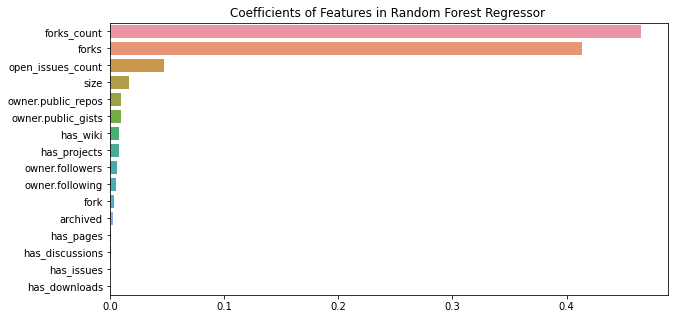

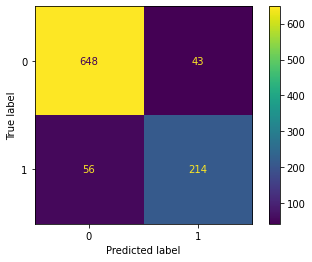

========================Classification Metrics======================
RF Accuracy : 0.8969823100936525
RF Precision : 0.8326848249027238
RF Recall : 0.7925925925925926
RF F1-Score : 0.8121442125237192
========================Cross Validation Metrics======================
RF 5-fold Mean Accuracy : 0.8716975429017161
RF 5-fold Mean Precision : 0.8999325272462941
RF 5-fold Mean Recall : 0.8716975429017161
RF 5-fold Mean F1-Score : 0.87235035141475


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.model_selection import cross_val_score

feature_names = X_norm.columns
best_feature_names_RF = []
rf_reg = RandomForestRegressor(max_depth=10, random_state=0)
rf_reg.fit(X_train_n,y_train_n)

rf_sfm = SelectFromModel(rf_reg)
rf_sfm.fit(X_train_n, y_train_n)
best_feature_names_RF.append(feature_names[rf_sfm.get_support()])
y_pred = rf_reg.predict(X_test_n)
print("Random Forest Tree R2 score: ",rf_reg.score(X_test_n, y_test_n))
print("Random Forest MSE: ",metrics.mean_squared_error(y_test_n, y_pred))
print("Random Forest MAE: ",metrics.mean_absolute_error(y_test_n, y_pred))

cv = cross_val_score(rf_reg, X_norm, y, cv=5, scoring="r2")
print(f"Random Forest 5-Fold R2 score N({cv.mean()}, {cv.std()})")
print(best_feature_names_RF)

f_i = list(zip(feature_names,rf_reg.feature_importances_))
f_i.sort(key = lambda x : x[1],reverse=True)
plt.figure(figsize=(10,5))
plt.title('Coefficients of Features in Random Forest Regressor ')
sns.barplot(y=[x[0] for x in f_i],x=[x[1] for x in f_i])

y_pred_cut = cut_y_bin(y_pred)

cm = metrics.confusion_matrix(y_test_cutted_bin, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("RF Accuracy :",metrics.accuracy_score(y_test_cutted_bin, y_pred_cut))
print("RF Precision :",metrics.precision_score(y_test_cutted_bin, y_pred_cut))
print("RF Recall :",metrics.recall_score(y_test_cutted_bin, y_pred_cut))
print("RF F1-Score :",metrics.f1_score(y_test_cutted_bin, y_pred_cut))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(rf_reg,X_norm,y,cut_y_bin)
print("RF 5-fold Mean Accuracy :",np.mean(accuracy))
print("RF 5-fold Mean Precision :",np.mean(precision))
print("RF 5-fold Mean Recall :",np.mean(recall))
print("RF 5-fold Mean F1-Score :",np.mean(f1_score))


### Best Features by Random Linear Regression

LinearRegression R2 score:  0.5385445594331342
LinearRegression MSE:  217734.09774566803
LinearRegression MAE:  57.12487110533867
LinearRegression 5-Fold R2 score N(0.4959712162963794, 0.4526926108559857)


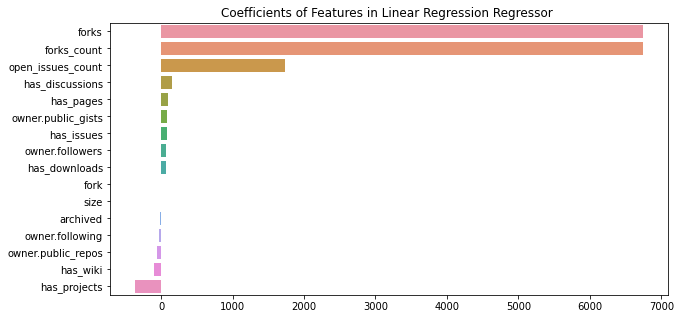

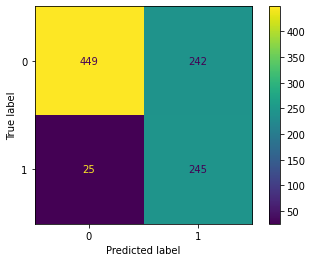

========================Classification Metrics======================
LinearRegression Accuracy : 0.7221644120707597
LinearRegression Precision : 0.5030800821355236
LinearRegression Recall : 0.9074074074074074
LinearRegression F1-Score : 0.6472919418758257
========================Cross Validation Metrics======================
LinearRegression 5-fold Mean Accuracy : 0.5022811037441497
LinearRegression 5-fold Mean Precision : 0.7283659732598953
LinearRegression 5-fold Mean Recall : 0.5022811037441497
LinearRegression 5-fold Mean F1-Score : 0.4802272023535334


In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_n, y_train_n)
y_pred = lin_reg.predict(X_test_n)
print("LinearRegression R2 score: ",lin_reg.score(X_test_n, y_test_n))
print("LinearRegression MSE: ",metrics.mean_squared_error(y_test_n, y_pred))
print("LinearRegression MAE: ",metrics.mean_absolute_error(y_test_n, y_pred))
cv = cross_val_score(lin_reg, X_norm, y, cv=5, scoring="r2")
print(f"LinearRegression 5-Fold R2 score N({cv.mean()}, {cv.std()})")

f_i = list(zip(X_norm.columns,lin_reg.coef_))
f_i.sort(key = lambda x : x[1],reverse=True)
plt.figure(figsize=(10,5))
plt.title('Coefficients of Features in Linear Regression Regressor ')
sns.barplot(y=[x[0] for x in f_i],x=[x[1] for x in f_i])
plt.show()

y_pred[y_pred<0]=0
y_pred_cut = cut_y_bin(y_pred)
cm = metrics.confusion_matrix(y_test_cutted_bin, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("LinearRegression Accuracy :",metrics.accuracy_score(y_test_cutted_bin, y_pred_cut))
print("LinearRegression Precision :",metrics.precision_score(y_test_cutted_bin, y_pred_cut))
print("LinearRegression Recall :",metrics.recall_score(y_test_cutted_bin, y_pred_cut))
print("LinearRegression F1-Score :",metrics.f1_score(y_test_cutted_bin, y_pred_cut))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(lin_reg,X_norm,y,cut_y_bin)
print("LinearRegression 5-fold Mean Accuracy :",np.mean(accuracy))
print("LinearRegression 5-fold Mean Precision :",np.mean(precision))
print("LinearRegression 5-fold Mean Recall :",np.mean(recall))
print("LinearRegression 5-fold Mean F1-Score :",np.mean(f1_score))


## Regression Models and Binary classification

### Decision Tree Regression

Decision Tree R2 score:  0.4537556370391419
Decision Tree MSE:  257741.0797710718
Decision Tree MAE:  56.36711758584808
Decision Tree 5-Fold R2 score N(0.3656750471012195, 0.40713436086701704)


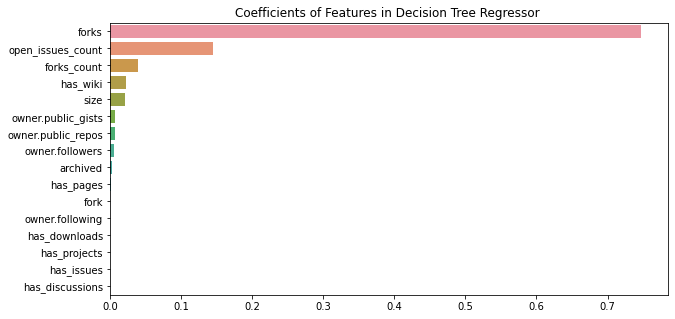

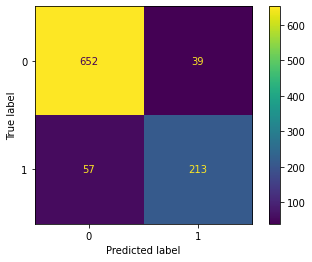

========================Classification Metrics======================
Decision Tree Accuracy : 0.9001040582726326
Decision Tree Precision : 0.8452380952380952
Decision Tree Recall : 0.7888888888888889
Decision Tree F1-Score : 0.8160919540229884
========================Cross Validation Metrics======================
Decision Tree 5-fold Mean Accuracy : 0.8395388065522621
Decision Tree 5-fold Mean Precision : 0.8574645722675613
Decision Tree 5-fold Mean Recall : 0.8395388065522621
Decision Tree 5-fold Mean F1-Score : 0.8393088528362552


In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor

dt_regressor = DecisionTreeRegressor(criterion="squared_error")
dt_regressor.fit(X_train_n, y_train_n)
y_pred = dt_regressor.predict(X_test_n)
print("Decision Tree R2 score: ",dt_regressor.score(X_test_n, y_test_n))
print("Decision Tree MSE: ",metrics.mean_squared_error(y_test_n, y_pred))
print("Decision Tree MAE: ",metrics.mean_absolute_error(y_test_n, y_pred))
cv = cross_val_score(dt_regressor, X_norm, y, cv=5, scoring="r2")
print(f"Decision Tree 5-Fold R2 score N({cv.mean()}, {cv.std()})")

f_i = list(zip(X_norm.columns,dt_regressor.feature_importances_))
f_i.sort(key = lambda x : x[1],reverse=True)
plt.figure(figsize=(10,5))
plt.title('Coefficients of Features in Decision Tree Regressor ')
sns.barplot(y=[x[0] for x in f_i],x=[x[1] for x in f_i])

y_pred[y_pred<0]=0
y_pred_cut = cut_y_bin(y_pred)
cm = metrics.confusion_matrix(y_test_cutted_bin, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("Decision Tree Accuracy :",metrics.accuracy_score(y_test_cutted_bin, y_pred_cut))
print("Decision Tree Precision :",metrics.precision_score(y_test_cutted_bin, y_pred_cut))
print("Decision Tree Recall :",metrics.recall_score(y_test_cutted_bin, y_pred_cut))
print("Decision Tree F1-Score :",metrics.f1_score(y_test_cutted_bin, y_pred_cut))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(dt_regressor,X_norm,y,cut_y_bin)
print("Decision Tree 5-fold Mean Accuracy :",np.mean(accuracy))
print("Decision Tree 5-fold Mean Precision :",np.mean(precision))
print("Decision Tree 5-fold Mean Recall :",np.mean(recall))
print("Decision Tree 5-fold Mean F1-Score :",np.mean(f1_score))

### KNN Regression

KNN R2 score:  0.37989184536139187
KNN MSE:  292593.1253277836
KNN MAE:  67.66285119667015
KNN 5-Fold R2 score N(0.01480803274517839, 0.8334967731367677)


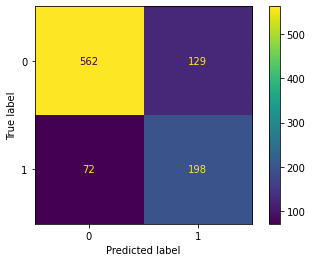

========================Classification Metrics======================
KNN Accuracy : 0.7908428720083247
KNN Precision : 0.6055045871559633
KNN Recall : 0.7333333333333333
KNN F1-Score : 0.6633165829145728
========================Cross Validation Metrics======================
KNN 5-fold Mean Accuracy : 0.7705421216848674
KNN 5-fold Mean Precision : 0.7832752127825582
KNN 5-fold Mean Recall : 0.7705421216848674
KNN 5-fold Mean F1-Score : 0.7722831906112185


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train_n,y_train_n)
y_pred = knn_regressor.predict(X_test_n)
print("KNN R2 score: ",knn_regressor.score(X_test_n,y_test_n))
print("KNN MSE: ",metrics.mean_squared_error(y_test_n,y_pred))
print("KNN MAE: ",metrics.mean_absolute_error(y_test_n,y_pred))

cv = cross_val_score(knn_regressor, X_norm, y, cv=5,scoring="r2")
print(f"KNN 5-Fold R2 score N({cv.mean()}, {cv.std()})")

y_pred[y_pred<0]=0
y_pred_cut = cut_y_bin(y_pred)
cm = metrics.confusion_matrix(y_test_cutted_bin, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("KNN Accuracy :",metrics.accuracy_score(y_test_cutted_bin, y_pred_cut))
print("KNN Precision :",metrics.precision_score(y_test_cutted_bin, y_pred_cut))
print("KNN Recall :",metrics.recall_score(y_test_cutted_bin, y_pred_cut))
print("KNN F1-Score :",metrics.f1_score(y_test_cutted_bin, y_pred_cut))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(knn_regressor,X_norm,y,cut_y_bin)
print("KNN 5-fold Mean Accuracy :",np.mean(accuracy))
print("KNN 5-fold Mean Precision :",np.mean(precision))
print("KNN 5-fold Mean Recall :",np.mean(recall))
print("KNN 5-fold Mean F1-Score :",np.mean(f1_score))

### MLP Regression

MLP R2 score:  0.5917478965657068
MLP 5-Fold R2 score N(0.07254799747925327, 0.36224582596480887)
MLP MSE:  192630.5241625092
MLP MAE:  73.82339091765934


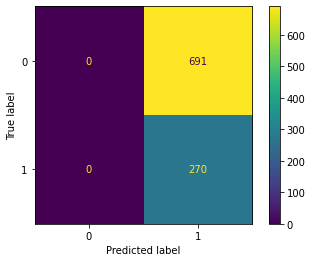

========================Classification Metrics======================
MLP Accuracy : 0.2809573361082206
MLP Precision : 0.2809573361082206
MLP Recall : 1.0
MLP F1-Score : 0.43866774979691303
========================Cross Validation Metrics======================


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

MLP 5-fold Mean Accuracy : 0.368798751950078
MLP 5-fold Mean Precision : 0.16662931393913322
MLP 5-fold Mean Recall : 0.368798751950078
MLP 5-fold Mean F1-Score : 0.21904618098897805


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor

params = {
  "hidden_layer_sizes":(300,100,50),
  "activation":"relu",
  "solver":"adam",
  "learning_rate":"adaptive", 
  "learning_rate_init":0.3,
}
MLP_regressor = MLPRegressor(**params)
MLP_regressor.fit(X=X_train_n,y= y_train_n)
y_pred = MLP_regressor.predict(X_test_n)
cv=cross_val_score(MLP_regressor,X=X_norm,y=y,cv=5,scoring="r2")
print("MLP R2 score: ",MLP_regressor.score(X_test_n,y_test_n))
print(f"MLP 5-Fold R2 score N({cv.mean()}, {cv.std()})")
print("MLP MSE: ",metrics.mean_squared_error(y_test_n,y_pred))
print("MLP MAE: ",metrics.mean_absolute_error(y_test_n,y_pred))

y_pred[y_pred<0]=0
y_pred_cut = cut_y_bin(y_pred)
cm = metrics.confusion_matrix(y_test_cutted_bin, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("MLP Accuracy :",metrics.accuracy_score(y_test_cutted_bin, y_pred_cut))
print("MLP Precision :",metrics.precision_score(y_test_cutted_bin, y_pred_cut))
print("MLP Recall :",metrics.recall_score(y_test_cutted_bin, y_pred_cut))
print("MLP F1-Score :",metrics.f1_score(y_test_cutted_bin, y_pred_cut))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(MLP_regressor,X_norm,y,cut_y_bin)
print("MLP 5-fold Mean Accuracy :",np.mean(accuracy))
print("MLP 5-fold Mean Precision :",np.mean(precision))
print("MLP 5-fold Mean Recall :",np.mean(recall))
print("MLP 5-fold Mean F1-Score :",np.mean(f1_score))

### AdaBoost Regressor

AdaBoost R2 score: 0.49306566837590204
AdaBoost MSE: 239192.95257822928
AdaBoost MAE: 194.6790999983955
AdaBoost 5-Fold R2 score N(0.05032177125659165, 1.2436640542017898)


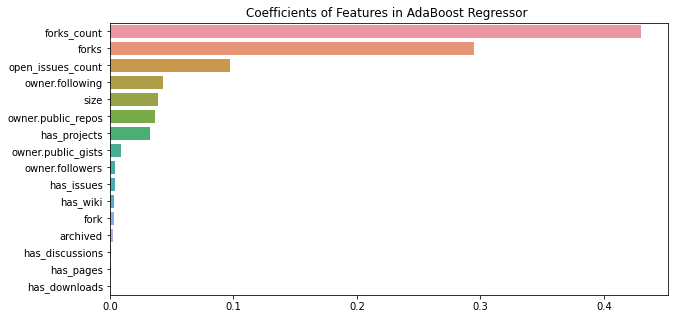

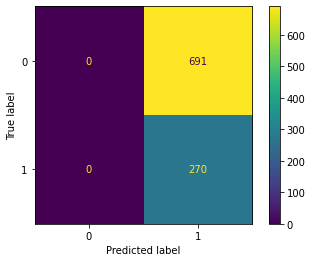

========================Classification Metrics======================
AdaBoost Accuracy : 0.2809573361082206
AdaBoost Precision : 0.2809573361082206
AdaBoost Recall : 1.0
AdaBoost F1-Score : 0.43866774979691303
========================Cross Validation Metrics======================


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

AdaBoost 5-fold Mean Accuracy : 0.281298751950078
AdaBoost 5-fold Mean Precision : 0.07912931393913322
AdaBoost 5-fold Mean Recall : 0.281298751950078
AdaBoost 5-fold Mean F1-Score : 0.12351403021292484


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import AdaBoostRegressor

AdaBoost_regressor = AdaBoostRegressor(n_estimators=50,random_state=0)
AdaBoost_regressor.fit(X_train_n,y_train_n)
y_pred = AdaBoost_regressor.predict(X_test_n)
print("AdaBoost R2 score:", AdaBoost_regressor.score(X_test_n, y_test_n))
print("AdaBoost MSE:", metrics.mean_squared_error(y_test_n, y_pred))
print("AdaBoost MAE:", metrics.mean_absolute_error(y_test_n, y_pred))

scores = cross_val_score(AdaBoost_regressor, X_norm, y, cv=5,scoring="r2")
print(f"AdaBoost 5-Fold R2 score N({scores.mean()}, {scores.std()})")

f_i = list(zip(X_norm.columns,AdaBoost_regressor.feature_importances_))
f_i.sort(key = lambda x : x[1],reverse=True)
plt.figure(figsize=(10,5))
plt.title('Coefficients of Features in AdaBoost Regressor ')
sns.barplot(y=[x[0] for x in f_i],x=[x[1] for x in f_i])

y_pred[y_pred<0]=0
y_pred_cut = cut_y_bin(y_pred)
cm = metrics.confusion_matrix(y_test_cutted_bin, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("AdaBoost Accuracy :",metrics.accuracy_score(y_test_cutted_bin, y_pred_cut))
print("AdaBoost Precision :",metrics.precision_score(y_test_cutted_bin, y_pred_cut))
print("AdaBoost Recall :",metrics.recall_score(y_test_cutted_bin, y_pred_cut))
print("AdaBoost F1-Score :",metrics.f1_score(y_test_cutted_bin, y_pred_cut))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(AdaBoost_regressor,X_norm,y,cut_y_bin)
print("AdaBoost 5-fold Mean Accuracy :",np.mean(accuracy))
print("AdaBoost 5-fold Mean Precision :",np.mean(precision))
print("AdaBoost 5-fold Mean Recall :",np.mean(recall))
print("AdaBoost 5-fold Mean F1-Score :",np.mean(f1_score))

### Bagging (Ensemble Learning)

Bagging (Ensemble Learning) R2 score: 0.5331812305775288
Bagging (Ensemble Learning) MSE: 220264.74202164414
Bagging (Ensemble Learning) MAE: 46.267741935483876
Bagging 5-Fold R2 score N(0.529822289149744, 0.1640004249530775)


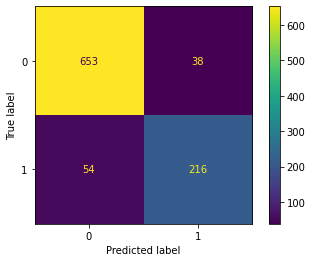

========================Classification Metrics======================
Bagging Accuracy : 0.9042663891779397
Bagging Precision : 0.8503937007874016
Bagging Recall : 0.8
Bagging F1-Score : 0.8244274809160306
========================Cross Validation Metrics======================
Bagging 5-fold Mean Accuracy : 0.849838143525741
Bagging 5-fold Mean Precision : 0.8667788185917358
Bagging 5-fold Mean Recall : 0.849838143525741
Bagging 5-fold Mean F1-Score : 0.8496846031189861


In [ ]:
from sklearn.ensemble import BaggingRegressor

bagging_regressor = BaggingRegressor(n_estimators=50,random_state=0,bootstrap=False)
bagging_regressor.fit(X_train_n,y_train_n)
y_pred = bagging_regressor.predict(X_test_n)
print("Bagging (Ensemble Learning) R2 score:", bagging_regressor.score(X_test_n, y_test_n))
print("Bagging (Ensemble Learning) MSE:", metrics.mean_squared_error(y_test_n, y_pred))
print("Bagging (Ensemble Learning) MAE:", metrics
      .mean_absolute_error(y_test_n, y_pred))
scores = cross_val_score(bagging_regressor, X_norm, y, cv=5,scoring="r2")
print(f"Bagging 5-Fold R2 score N({scores.mean()}, {scores.std()})")

y_pred[y_pred<0]=0
y_pred_cut = cut_y_bin(y_pred)
cm = metrics.confusion_matrix(y_test_cutted_bin, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("Bagging Accuracy :",metrics.accuracy_score(y_test_cutted_bin, y_pred_cut))
print("Bagging Precision :",metrics.precision_score(y_test_cutted_bin, y_pred_cut))
print("Bagging Recall :",metrics.recall_score(y_test_cutted_bin, y_pred_cut))
print("Bagging F1-Score :",metrics.f1_score(y_test_cutted_bin, y_pred_cut))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(bagging_regressor,X_norm,y,cut_y_bin)
print("Bagging 5-fold Mean Accuracy :",np.mean(accuracy))
print("Bagging 5-fold Mean Precision :",np.mean(precision))
print("Bagging 5-fold Mean Recall :",np.mean(recall))
print("Bagging 5-fold Mean F1-Score :",np.mean(f1_score))

### XGBoost Regressor

[21:43:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost R2 score: 0.594864237638784
XGBoost MSE: 191160.10328941105
XGBoost MAE: 45.15470210124005
[21:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost 5-Fold R2 score N(0.6000207310409587, 0.2862200566594196)


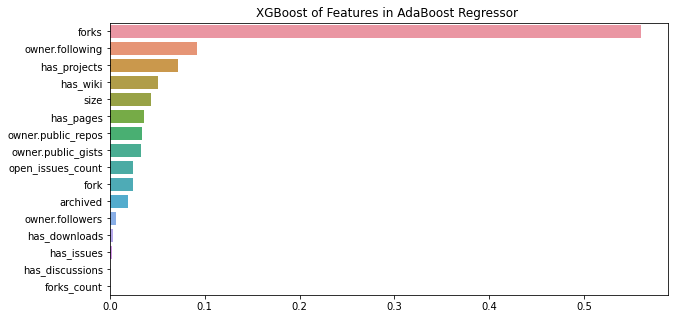

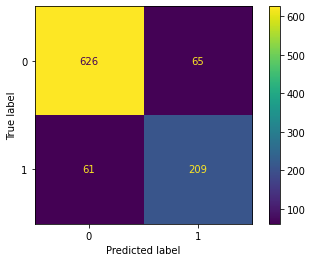

========================Classification Metrics======================
XGBoost Accuracy : 0.8688865764828304
XGBoost Precision : 0.7627737226277372
XGBoost Recall : 0.774074074074074
XGBoost F1-Score : 0.7683823529411764
========================Cross Validation Metrics======================
[21:43:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost 5-fold Mean Accuracy : 0.8591980304212168
XGBoost 5-fold Mean Preci

In [ ]:
import xgboost as xgb

xgb_regressor = xgb.XGBRegressor(objective="reg:linear", random_state=42)
xgb_regressor.fit(X_train_n, y_train_n)
y_pred = xgb_regressor.predict(X_test_n)
print("XGBoost R2 score:", xgb_regressor.score(X_test_n, y_test_n))
print("XGBoost MSE:", metrics.mean_squared_error(y_test_n, y_pred))
print("XGBoost MAE:", metrics.mean_absolute_error(y_test_n, y_pred))

scores = cross_val_score(xgb_regressor, X_norm, y, cv=5,scoring="r2")
print(f"XGBoost 5-Fold R2 score N({scores.mean()}, {scores.std()})")

f_i = list(zip(X_norm.columns,xgb_regressor.feature_importances_))
f_i.sort(key = lambda x : x[1],reverse=True)
plt.figure(figsize=(10,5))
plt.title('XGBoost of Features in AdaBoost Regressor ')
sns.barplot(y=[x[0] for x in f_i],x=[x[1] for x in f_i])

y_pred[y_pred<0]=0
y_pred_cut = cut_y_bin(y_pred)
cm = metrics.confusion_matrix(y_test_cutted_bin, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("XGBoost Accuracy :",metrics.accuracy_score(y_test_cutted_bin, y_pred_cut))
print("XGBoost Precision :",metrics.precision_score(y_test_cutted_bin, y_pred_cut))
print("XGBoost Recall :",metrics.recall_score(y_test_cutted_bin, y_pred_cut))
print("XGBoost F1-Score :",metrics.f1_score(y_test_cutted_bin, y_pred_cut))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(xgb_regressor,X_norm,y,cut_y_bin)
print("XGBoost 5-fold Mean Accuracy :",np.mean(accuracy))
print("XGBoost 5-fold Mean Precision :",np.mean(precision))
print("XGBoost 5-fold Mean Recall :",np.mean(recall))
print("XGBoost 5-fold Mean F1-Score :",np.mean(f1_score))

## Regression Models and Binary classification

In [ ]:
y_test_cutted = cut_y(y_test_n)


### Random Forest and Multi_class Classification

<Figure size 720x720 with 0 Axes>

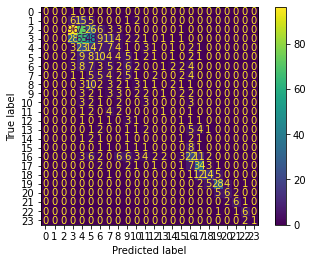

========================Classification Metrics======================
RF Accuracy : 0.19250780437044746
RF Precision : 0.17591703140945691
RF Recall : 0.19250780437044746
RF F1-Score : 0.1767323547729957
========================Cross Validation Metrics======================


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet

RF 5-fold Mean Accuracy : 0.19295485569422777
RF 5-fold Mean Precision : 0.1717624027622422
RF 5-fold Mean Recall : 0.19295485569422777
RF 5-fold Mean F1-Score : 0.173109211240216


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
rf_reg = RandomForestRegressor(max_depth=10, random_state=0)
rf_reg.fit(X_train_n,y_train_n)
y_pred = rf_reg.predict(X_test_n)

y_pred_cut = cut_y(y_pred)

cm = metrics.confusion_matrix(y_test_cutted, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("RF Accuracy :",metrics.accuracy_score(y_test_cutted, y_pred_cut))
print("RF Precision :",metrics.precision_score(y_test_cutted, y_pred_cut,average='weighted'))
print("RF Recall :",metrics.recall_score(y_test_cutted, y_pred_cut,average='weighted'))
print("RF F1-Score :",metrics.f1_score(y_test_cutted, y_pred_cut,average='weighted'))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(rf_reg,X_norm,y,cut_y)
print("RF 5-fold Mean Accuracy :",np.mean(accuracy))
print("RF 5-fold Mean Precision :",np.mean(precision))
print("RF 5-fold Mean Recall :",np.mean(recall))
print("RF 5-fold Mean F1-Score :",np.mean(f1_score))


### LinearRegression and Multi_class Classification

<Figure size 720x720 with 0 Axes>

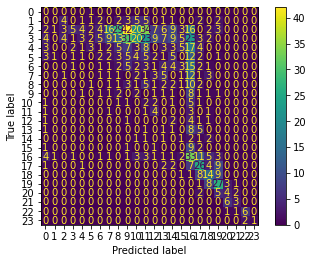

========================Classification Metrics======================
LinearRegression Accuracy : 0.12903225806451613
LinearRegression Precision : 0.16002079535442978
LinearRegression Recall : 0.12903225806451613
LinearRegression F1-Score : 0.10539356752804006
========================Cross Validation Metrics======================
LinearRegression 5-fold Mean Accuracy : 0.10646060842433695
LinearRegression 5-fold Mean Precision : 0.1933069518820218
LinearRegression 5-fold Mean Recall : 0.10646060842433695
LinearRegression 5-fold Mean F1-Score : 0.08487230417876493


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control th

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_n, y_train_n)
y_pred = lin_reg.predict(X_test_n)
y_pred[y_pred<0]=0
y_pred_cut = cut_y(y_pred)
cm = metrics.confusion_matrix(y_test_cutted, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("LinearRegression Accuracy :",metrics.accuracy_score(y_test_cutted, y_pred_cut))
print("LinearRegression Precision :",metrics.precision_score(y_test_cutted, y_pred_cut,average='weighted'))
print("LinearRegression Recall :",metrics.recall_score(y_test_cutted, y_pred_cut,average='weighted'))
print("LinearRegression F1-Score :",metrics.f1_score(y_test_cutted, y_pred_cut,average='weighted'))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(lin_reg,X_norm,y,cut_y)
print("LinearRegression 5-fold Mean Accuracy :",np.mean(accuracy))
print("LinearRegression 5-fold Mean Precision :",np.mean(precision))
print("LinearRegression 5-fold Mean Recall :",np.mean(recall))
print("LinearRegression 5-fold Mean F1-Score :",np.mean(f1_score))


### Decision Tree and Multi_class Classification

<Figure size 720x720 with 0 Axes>

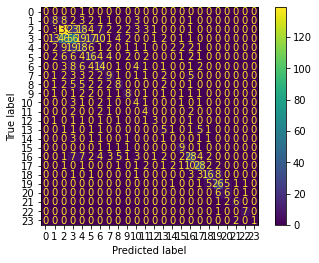

========================Classification Metrics======================
Decision Tree Accuracy : 0.43600416233090533
Decision Tree Precision : 0.44386694834686846
Decision Tree Recall : 0.43600416233090533
Decision Tree F1-Score : 0.43668322691758377
========================Cross Validation Metrics======================
Decision Tree 5-fold Mean Accuracy : 0.3197089508580343
Decision Tree 5-fold Mean Precision : 0.31955572906133023
Decision Tree 5-fold Mean Recall : 0.3197089508580343
Decision Tree 5-fold Mean F1-Score : 0.31176999684717793


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

In [ ]:

dt_regressor = DecisionTreeRegressor(criterion="squared_error")
dt_regressor.fit(X_train_n, y_train_n)
y_pred = dt_regressor.predict(X_test_n)

y_pred[y_pred<0]=0
y_pred_cut = cut_y(y_pred)
cm = metrics.confusion_matrix(y_test_cutted, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("Decision Tree Accuracy :",metrics.accuracy_score(y_test_cutted, y_pred_cut))
print("Decision Tree Precision :",metrics.precision_score(y_test_cutted, y_pred_cut,average='weighted'))
print("Decision Tree Recall :",metrics.recall_score(y_test_cutted, y_pred_cut,average='weighted'))
print("Decision Tree F1-Score :",metrics.f1_score(y_test_cutted, y_pred_cut,average='weighted'))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(dt_regressor,X_norm,y,cut_y)
print("Decision Tree 5-fold Mean Accuracy :",np.mean(accuracy))
print("Decision Tree 5-fold Mean Precision :",np.mean(precision))
print("Decision Tree 5-fold Mean Recall :",np.mean(recall))
print("Decision Tree 5-fold Mean F1-Score :",np.mean(f1_score))

### KNN and Multi_class Classification

<Figure size 720x720 with 0 Axes>

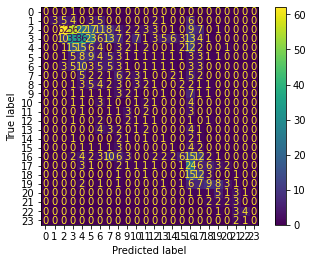

========================Classification Metrics======================
KNN Accuracy : 0.1841831425598335
KNN Precision : 0.30893283029621565
KNN Recall : 0.1841831425598335
KNN F1-Score : 0.2089567605678718
========================Cross Validation Metrics======================


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet

KNN 5-fold Mean Accuracy : 0.17483034321372853
KNN 5-fold Mean Precision : 0.2884850599974259
KNN 5-fold Mean Recall : 0.17483034321372853
KNN 5-fold Mean F1-Score : 0.1937426134318038


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train_n,y_train_n)
y_pred = knn_regressor.predict(X_test_n)

y_pred[y_pred<0]=0
y_pred_cut = cut_y(y_pred)
cm = metrics.confusion_matrix(y_test_cutted, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("KNN Accuracy :",metrics.accuracy_score(y_test_cutted, y_pred_cut))
print("KNN Precision :",metrics.precision_score(y_test_cutted, y_pred_cut,average='weighted'))
print("KNN Recall :",metrics.recall_score(y_test_cutted, y_pred_cut,average='weighted'))
print("KNN F1-Score :",metrics.f1_score(y_test_cutted, y_pred_cut,average='weighted'))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(knn_regressor,X_norm,y,cut_y)
print("KNN 5-fold Mean Accuracy :",np.mean(accuracy))
print("KNN 5-fold Mean Precision :",np.mean(precision))
print("KNN 5-fold Mean Recall :",np.mean(recall))
print("KNN 5-fold Mean F1-Score :",np.mean(f1_score))

### MLP and Multi_class Classification

<Figure size 720x720 with 0 Axes>

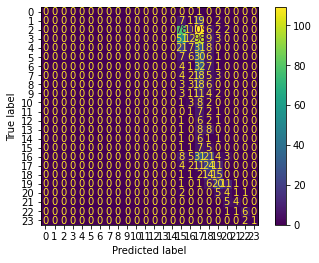

========================Classification Metrics======================
MLP Accuracy : 0.06867845993756504
MLP Precision : 0.03915755831174017
MLP Recall : 0.06867845993756504
MLP F1-Score : 0.04374673851230777
========================Cross Validation Metrics======================


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet

MLP 5-fold Mean Accuracy : 0.08960413416536663
MLP 5-fold Mean Precision : 0.04702218923323333
MLP 5-fold Mean Recall : 0.08960413416536663
MLP 5-fold Mean F1-Score : 0.043474736975280426


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
params = {
  "hidden_layer_sizes":(300,100,50),
  "activation":"relu",
  "solver":"adam",
  "learning_rate":"adaptive", 
  "learning_rate_init":0.3,
}
MLP_regressor = MLPRegressor(**params)
MLP_regressor.fit(X=X_train_n,y= y_train_n)
y_pred = MLP_regressor.predict(X_test_n)

y_pred[y_pred<0]=0
y_pred_cut = cut_y(y_pred)
cm = metrics.confusion_matrix(y_test_cutted, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("MLP Accuracy :",metrics.accuracy_score(y_test_cutted, y_pred_cut))
print("MLP Precision :",metrics.precision_score(y_test_cutted, y_pred_cut,average='weighted'))
print("MLP Recall :",metrics.recall_score(y_test_cutted, y_pred_cut,average='weighted'))
print("MLP F1-Score :",metrics.f1_score(y_test_cutted, y_pred_cut,average='weighted'))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(MLP_regressor,X_norm,y,cut_y)
print("MLP 5-fold Mean Accuracy :",np.mean(accuracy))
print("MLP 5-fold Mean Precision :",np.mean(precision))
print("MLP 5-fold Mean Recall :",np.mean(recall))
print("MLP 5-fold Mean F1-Score :",np.mean(f1_score))

### Adaboost and Multi_class Classification

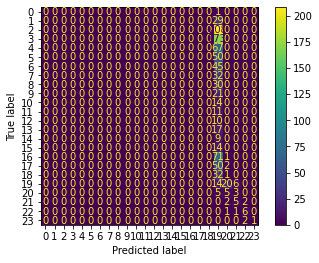

========================Classification Metrics======================
AdaBoost Accuracy : 0.03225806451612903
AdaBoost Precision : 0.013997299728157846
AdaBoost Recall : 0.03225806451612903
AdaBoost F1-Score : 0.015254860619908736
========================Cross Validation Metrics======================


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet

AdaBoost 5-fold Mean Accuracy : 0.05681747269890795
AdaBoost 5-fold Mean Precision : 0.03200594735970799
AdaBoost 5-fold Mean Recall : 0.05681747269890795
AdaBoost 5-fold Mean F1-Score : 0.033175781070575165


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

AdaBoost_regressor = AdaBoostRegressor(n_estimators=50,random_state=0)
AdaBoost_regressor.fit(X_train_n,y_train_n)
y_pred = AdaBoost_regressor.predict(X_test_n)

y_pred[y_pred<0]=0
y_pred_cut = cut_y(y_pred)
cm = metrics.confusion_matrix(y_test_cutted, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("AdaBoost Accuracy :",metrics.accuracy_score(y_test_cutted, y_pred_cut))
print("AdaBoost Precision :",metrics.precision_score(y_test_cutted, y_pred_cut,average='weighted'))
print("AdaBoost Recall :",metrics.recall_score(y_test_cutted, y_pred_cut,average='weighted'))
print("AdaBoost F1-Score :",metrics.f1_score(y_test_cutted, y_pred_cut,average='weighted'))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(AdaBoost_regressor,X_norm,y,cut_y)
print("AdaBoost 5-fold Mean Accuracy :",np.mean(accuracy))
print("AdaBoost 5-fold Mean Precision :",np.mean(precision))
print("AdaBoost 5-fold Mean Recall :",np.mean(recall))
print("AdaBoost 5-fold Mean F1-Score :",np.mean(f1_score))

### Bagging and Multi_class Classification

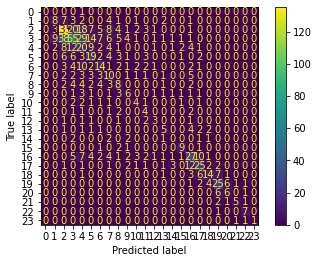

========================Classification Metrics======================
Bagging Accuracy : 0.4266389177939646
Bagging Precision : 0.4480969974649538
Bagging Recall : 0.4266389177939646
Bagging F1-Score : 0.43133029093162306
========================Cross Validation Metrics======================


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

Bagging 5-fold Mean Accuracy : 0.31814742589703593
Bagging 5-fold Mean Precision : 0.3291146004080437
Bagging 5-fold Mean Recall : 0.31814742589703593
Bagging 5-fold Mean F1-Score : 0.31543945400274503


In [ ]:
from sklearn.ensemble import BaggingRegressor

bagging_regressor = BaggingRegressor(n_estimators=50,random_state=0,bootstrap=False)
bagging_regressor.fit(X_train_n,y_train_n)
y_pred = bagging_regressor.predict(X_test_n)

y_pred[y_pred<0]=0
y_pred_cut = cut_y(y_pred)
cm = metrics.confusion_matrix(y_test_cutted, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("Bagging Accuracy :",metrics.accuracy_score(y_test_cutted, y_pred_cut))
print("Bagging Precision :",metrics.precision_score(y_test_cutted, y_pred_cut,average='weighted'))
print("Bagging Recall :",metrics.recall_score(y_test_cutted, y_pred_cut,average='weighted'))
print("Bagging F1-Score :",metrics.f1_score(y_test_cutted, y_pred_cut,average='weighted'))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(bagging_regressor,X_norm,y,cut_y)
print("Bagging 5-fold Mean Accuracy :",np.mean(accuracy))
print("Bagging 5-fold Mean Precision :",np.mean(precision))
print("Bagging 5-fold Mean Recall :",np.mean(recall))
print("Bagging 5-fold Mean F1-Score :",np.mean(f1_score))

### XGBoost and Multi_class Classification

[22:28:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


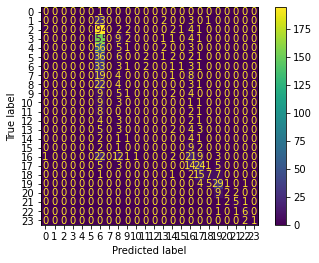

========================Classification Metrics======================
XGBoost Accuracy : 0.1383975026014568
XGBoost Precision : 0.10202070020704196
XGBoost Recall : 0.1383975026014568
XGBoost F1-Score : 0.10120957159831963
========================Cross Validation Metrics======================
[22:28:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:28:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet

[22:28:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:28:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost 5-fold Mean Accuracy : 0.13143330733229328
XGBoost 5-fold Mean Precision : 0.10612420145443094
XGBoost 5-fold Mean Recall : 0.13143330733229328
XGBoost 5-fold Mean F1-Score : 0.10470237401779345


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import xgboost as xgb

xgb_regressor = xgb.XGBRegressor(objective="reg:linear", random_state=42)
xgb_regressor.fit(X_train_n, y_train_n)
y_pred = xgb_regressor.predict(X_test_n)

y_pred[y_pred<0]=0
y_pred_cut = cut_y(y_pred)
cm = metrics.confusion_matrix(y_test_cutted, y_pred_cut)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print('========================Classification Metrics======================')
print("XGBoost Accuracy :",metrics.accuracy_score(y_test_cutted, y_pred_cut))
print("XGBoost Precision :",metrics.precision_score(y_test_cutted, y_pred_cut,average='weighted'))
print("XGBoost Recall :",metrics.recall_score(y_test_cutted, y_pred_cut,average='weighted'))
print("XGBoost F1-Score :",metrics.f1_score(y_test_cutted, y_pred_cut,average='weighted'))

print('========================Cross Validation Metrics======================')
accuracy,precision,recall,f1_score = kfold_cross_validation(xgb_regressor,X_norm,y,cut_y)
print("XGBoost 5-fold Mean Accuracy :",np.mean(accuracy))
print("XGBoost 5-fold Mean Precision :",np.mean(precision))
print("XGBoost 5-fold Mean Recall :",np.mean(recall))
print("XGBoost 5-fold Mean F1-Score :",np.mean(f1_score))